In [27]:
# Part 1: Data Loading & Exploration:
# Goal: 
# - Load only metadata.csv (sample a manageable number of rows)
# - Inspect first rows, shape, dtypes, missing values, and basic stats
import pandas as pd

# Try loading metadata.csv
# sample first 50,0000 rows
try:
    df = pd.read_csv("metadata.csv", low_memory=False, nrows=50000)
except FileNotFoundError:
    print("⚠️ metadata.csv not found. Please download from Kaggle and place it in this folder.")
    exit()

    # Show first few rows
print("\n--- First 20 Rows ---")
print(df.head(20))

# Shape of dataset
print("\n--- DataFrame dimensions (rows, columns) ---")
print(df.shape)

# Data types
print("\n--- Data types of each column ---")
print(df.dtypes)

# We'll focus on columns typically present in CORD-19 metadata:
important_cols = [c for c in ["title","abstract","journal","source_x","publish_time"] if c in df.columns]
print("\n--- Missing values in important columns ---")
print(df[important_cols].isnull().sum())

print("\n--- Basic statistics for numeric columns ---")
print(df.describe(include=[np.number]).T)


--- First 20 Rows ---
    cord_uid                                       sha source_x  \
0   ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1   02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2   ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3   2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4   9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   
5   zjufx4fo  b2897e1277f56641193a6db73825f707eed3e4c9      PMC   
6   5yhe786e  3bb07ea10432f7738413dff9816809cc90f03f99      PMC   
7   8zchiykl  5806726a24dc91de3954001effbdffd7a82d54e2      PMC   
8   8qnrcgnk  faaf1022ccfe93b032c5608097a53543ba24aedb      PMC   
9   jg13scgo  5b44feca5d6ffaaeb66501fa84cc6dd44d06660a      PMC   
10  5tkvsudh  9d4e3e8eb092d5ed282d0aa4aadcaa8b7165b5e9      PMC   
11  6lvn10f4  14e0cac6e86d62859e6c9f1351ab67466d89e5b3      PMC   
12  tvxpckxo  d09b79026117ec9faebba46a8d13aa9b23ec751e      PMC   
13  mcuixluu  44102e3e69e70ad2a73e75313

In [28]:
# Part 2: Data Cleaning & Preparation
# Goals:
# - Identify heavy-missing columns
# - Decide handling: drop/fill
# - Convert dates; derive year; create new helper columns (e.g., abstract word count)
# - Produce a cleaned dataset to save for later parts (incl. Streamlit)
# ---- 1) Identify columns with many missing values (e.g., >50% missing)
missing_ratio = df.isnull().mean().sort_values(ascending=False)
heavy_missing = missing_ratio[missing_ratio > 0.5]
print("\n--- Columns with >50% missing values ---")
print(heavy_missing)

# ---- 2) Create a working copy and standardize column names
work = df.copy()
work.columns = [c.strip().lower() for c in work.columns]

# ---- 3) Decide how to handle missing values
# • For analysis, rows without a title are not useful -> drop them
if "title" in work.columns:
    work = work.dropna(subset=["title"])

# • Journal: fill with "Unknown" for clarity
if "journal" in work.columns:
    work["journal"] = (
        work["journal"].fillna("Unknown").astype(str).str.strip().replace({"": "Unknown"})
    )

# ---- 4) Convert date column to datetime and derive "year"
if "publish_time" in work.columns:
    work["publish_time"] = pd.to_datetime(work["publish_time"], errors="coerce")
    work["year"] = work["publish_time"].dt.year
else:
    work["publish_time"] = pd.NaT
    work["year"] = np.nan

# ---- 5) Create new helper columns (example: abstract word count)
if "abstract" in work.columns:
    work["abstract_word_count"] = work["abstract"].fillna("").astype(str).str.split().str.len()
else:
    work["abstract_word_count"] = np.nan

# ---- 6) Quick post-cleaning snapshot
print("\n--- Missing values after cleaning (key columns) ---")
key_cols = [c for c in ["title","abstract","journal","publish_time","year"] if c in work.columns]
print(work[key_cols].isnull().sum())

print("\n--- Abstract word count stats ---")
print(work["abstract_word_count"].describe())

# ---- 7) Save a light cleaned CSV for the Streamlit app (Part 4)
lite_cols = [c for c in ["title","journal","source_x","publish_time","year","abstract_word_count"] if c in work.columns]
work[lite_cols].to_csv("cord19_clean_sample.csv", index=False)
print(f"\n✅ Saved cleaned sample to cord19_clean_sample.csv  (rows={len(work):,}, cols={len(lite_cols)})")


--- Columns with >50% missing values ---
who_covidence_id    1.0
arxiv_id            1.0
s2_id               1.0
mag_id              1.0
dtype: float64

--- Missing values after cleaning (key columns) ---
title               0
abstract        13997
journal             0
publish_time     2403
year             2403
dtype: int64

--- Abstract word count stats ---
count    50000.000000
mean       148.548120
std        157.386041
min          0.000000
25%          0.000000
50%        159.000000
75%        234.000000
max      18000.000000
Name: abstract_word_count, dtype: float64

✅ Saved cleaned sample to cord19_clean_sample.csv  (rows=50,000, cols=6)



--- Publications by Year (tail) ---
year
2013     1098
2014     1066
2015     1119
2016     1423
2017     1271
2018     1329
2019     1937
2020    11850
2021    10950
2022     6875
Name: count, dtype: int64


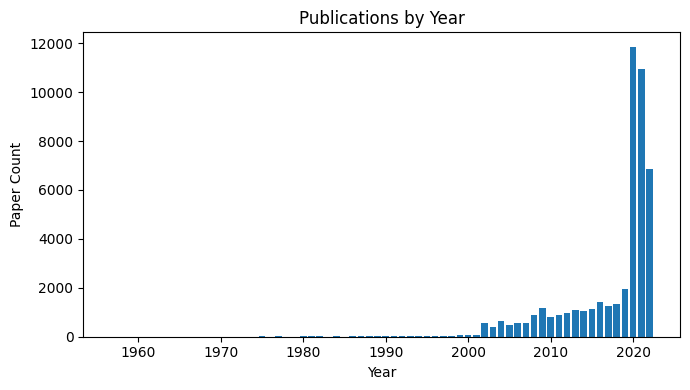


--- Top 10 Journals ---
journal
Viruses                               338
Intensive Care Med                    341
Computational Science - ICCS 2020     350
Int J Mol Sci                         421
Lancet                                425
Nat Commun                            470
Int J Environ Res Public Health       671
Sci Rep                               854
PLoS One                             1368
Unknown                              2492
Name: count, dtype: int64


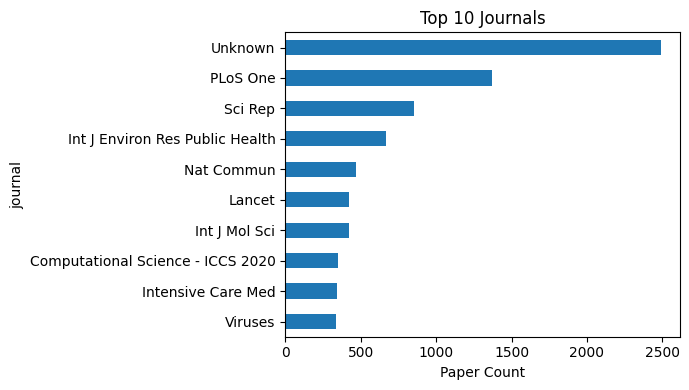


--- Top 20 title words ---
           word  count
0         virus   2858
1        health   2373
2      patients   2329
3       disease   1959
4     infection   1674
5   respiratory   1575
6         human   1563
7          cell   1517
8          care   1480
9     influenza   1459
10     clinical   1320
11        acute   1314
12        cells   1158
13       cancer   1155
14   associated   1093
15        viral   1084
16     diseases   1028
17    treatment   1025
18   infections   1014
19      protein    996


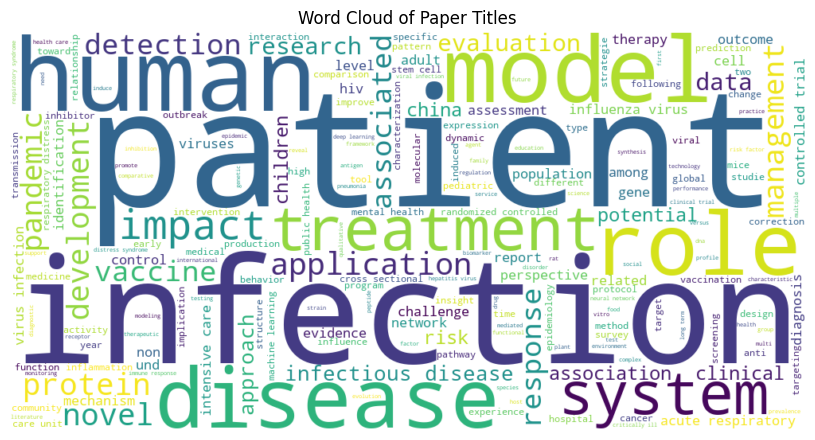


--- Top Sources ---
source_x
PMC    50000
Name: count, dtype: int64


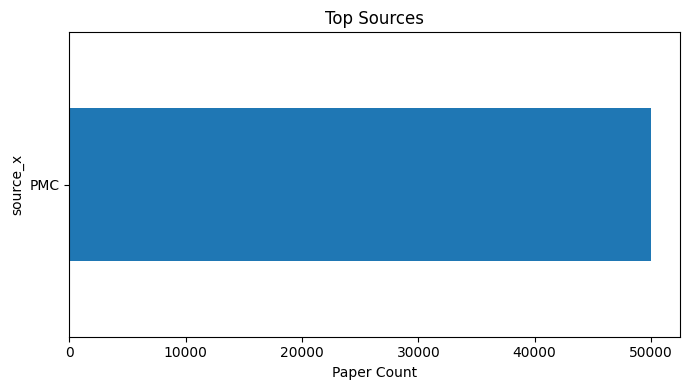

In [29]:
# ============================
# PART 3: DATA ANALYSIS & VISUALIZATION
# Goals:
# - Count papers by year
# - Top journals
# - Frequent words in titles (simple frequency)
# - Visualizations: publications over time, top journals, word cloud, source distribution
# ============================

import matplotlib.pyplot as plt
from collections import Counter
import re

# ---- 1) Publications by year
year_counts = work["year"].dropna().astype(int).value_counts().sort_index()
print("\n--- Publications by Year (tail) ---")
print(year_counts.tail(10))

plt.figure(figsize=(7,4))
plt.bar(year_counts.index, year_counts.values)
plt.title("Publications by Year")
plt.xlabel("Year")
plt.ylabel("Paper Count")
plt.tight_layout()
plt.show()

# ---- 2) Top journals publishing COVID-19 research
if "journal" in work.columns:
    top_journals = work["journal"].value_counts().head(10).sort_values()
    print("\n--- Top 10 Journals ---")
    print(top_journals)

    plt.figure(figsize=(7,4))
    top_journals.plot(kind="barh")
    plt.title("Top 10 Journals")
    plt.xlabel("Paper Count")
    plt.tight_layout()
    plt.show()

# ---- 3) Most frequent words in titles (simple word frequency)
stop = set("""
a an the and or for to of in on with without by from during after before
is are was were be been being this that these those it its their our your my we they he she
about as at not no yes using use based via new study analysis covid coronavirus sars cov 2
review case cases systematic meta analysis results methods conclusion effect effects
""".split())

def tokenize_title(t: str):
    words = re.findall(r"[A-Za-z']+", str(t).lower())
    return [w for w in words if len(w) > 2 and w not in stop]

tokens = []
for t in work["title"].dropna().astype(str):
    tokens.extend(tokenize_title(t))

freq = Counter(tokens).most_common(30)
freq_df = pd.DataFrame(freq, columns=["word","count"])
print("\n--- Top 20 title words ---")
print(freq_df.head(20))

# ---- 4) Word cloud (optional)
try:
    from wordcloud import WordCloud
except Exception:
    # install in-notebook if needed
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud"])
    from wordcloud import WordCloud

wc_text = " ".join(tokens) if tokens else "no data"
wc = WordCloud(width=1000, height=500, background_color="white").generate(wc_text)

plt.figure(figsize=(9,4.5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Paper Titles")
plt.tight_layout()
plt.show()

# ---- 5) Distribution of paper counts by source (if column exists)
if "source_x" in work.columns:
    src_counts = work["source_x"].fillna("Unknown").value_counts().head(12).sort_values()
    print("\n--- Top Sources ---")
    print(src_counts)

    plt.figure(figsize=(7,4))
    src_counts.plot(kind="barh")
    plt.title("Top Sources")
    plt.xlabel("Paper Count")
    plt.tight_layout()
    plt.show()


In [ ]:

# PART 4: STREAMLIT APPLICATION
# Run with: streamlit run app.py


import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re

st.set_page_config(page_title="CORD-19 Data Explorer", layout="wide")
st.title("CORD-19 Data Explorer")
st.write("Simple exploration of COVID-19 research papers (metadata sample).")

@st.cache_data
def load_data():
    # Prefer the cleaned file from Part 2; fallback to raw (sample first N rows)
    try:
        df = pd.read_csv("cord19_clean_sample.csv", parse_dates=["publish_time"])
    except Exception:
        df = pd.read_csv("metadata.csv", low_memory=False, nrows=50_000)
        # minimal cleaning to keep the app working
        df.columns = [c.lower() for c in df.columns]
        df["publish_time"] = pd.to_datetime(df.get("publish_time"), errors="coerce")
        if "year" not in df.columns:
            df["year"] = df["publish_time"].dt.year
        if "abstract_word_count" not in df.columns:
            df["abstract_word_count"] = df.get("abstract", "").fillna("").astype(str).str.split().str.len()
        if "journal" in df.columns:
            df["journal"] = df["journal"].fillna("Unknown").astype(str).str.strip().replace({"": "Unknown"})
    return df

df = load_data()
src_col = "source_x" if "source_x" in df.columns else None

# ---- Filters
left, right = st.columns([1,2])
with left:
    st.subheader("Filters")
    # year range slider
    min_year = int(df["year"].dropna().min()) if df["year"].notna().any() else 2019
    max_year = int(df["year"].dropna().max()) if df["year"].notna().any() else 2022
    year_range = st.slider("Select year range", min_year, max_year, (min_year, max_year))
    # journal dropdown
    if "journal" in df.columns:
        journals = ["All"] + sorted(df["journal"].dropna().unique().tolist())
        journal_pick = st.selectbox("Journal", journals, index=0)
    else:
        journal_pick = "All"
    # source dropdown (optional)
    if src_col:
        sources = ["All"] + sorted(df[src_col].fillna("Unknown").unique().tolist())
        source_pick = st.selectbox("Source", sources, index=0)
    else:
        source_pick = "All"

# ---- Apply filters
mask = df["year"].between(year_range[0], year_range[1], inclusive="both")
if journal_pick != "All" and "journal" in df.columns:
    mask &= df["journal"].eq(journal_pick)
if src_col and source_pick != "All":
    mask &= df[src_col].fillna("Unknown").eq(source_pick)

view = df.loc[mask].copy()

with right:
    st.subheader("Overview")
    c1, c2, c3, c4 = st.columns(4)
    c1.metric("Rows", f"{len(view):,}")
    c2.metric("Distinct Years", view["year"].nunique())
    c3.metric("Median Abstract Words", int(view["abstract_word_count"].median()) if view["abstract_word_count"].notna().any() else 0)
    c4.metric("Distinct Journals", view["journal"].nunique() if "journal" in view.columns else 0)

    # Publications by Year
    st.subheader("Publications by Year")
    year_counts = view["year"].dropna().astype(int).value_counts().sort_index()
    fig1, ax1 = plt.subplots(figsize=(6,3))
    ax1.bar(year_counts.index, year_counts.values)
    ax1.set_xlabel("Year"); ax1.set_ylabel("Count"); ax1.set_title("Publications by Year")
    st.pyplot(fig1, clear_figure=True)

    # Top Journals
    if "journal" in view.columns:
        st.subheader("Top Journals")
        topj = view["journal"].value_counts().head(10).sort_values()
        fig2, ax2 = plt.subplots(figsize=(6,3))
        topj.plot(kind="barh", ax=ax2)
        ax2.set_xlabel("Count"); ax2.set_title("Top 10 Journals")
        st.pyplot(fig2, clear_figure=True)

    # Source distribution
    if src_col:
        st.subheader("Top Sources")
        tops = view[src_col].fillna("Unknown").value_counts().head(12).sort_values()
        fig3, ax3 = plt.subplots(figsize=(6,3))
        tops.plot(kind="barh", ax=ax3)
        ax3.set_xlabel("Count"); ax3.set_title("Top Sources")
        st.pyplot(fig3, clear_figure=True)

    # Word Cloud (titles)
    st.subheader("Word Cloud (Titles)")
    stop = set("""
    a an the and or for to of in on with without by from during after before
    is are was were be been being this that these those it its their our your my we they he she
    about as at not no yes using use based via new study analysis covid coronavirus sars cov 2
    review case cases systematic meta analysis results methods conclusion effect effects
    """.split())

    def toks(t): 
        return [w for w in re.findall(r"[A-Za-z']+", str(t).lower()) if len(w)>2 and w not in stop]

    tokens = []
    for t in view["title"].dropna().astype(str).head(10000):  # cap for speed
        tokens.extend(toks(t))

    if tokens:
        try:
            from wordcloud import WordCloud
            wc = WordCloud(width=1000, height=500, background_color="white").generate(" ".join(tokens))
            fig4, ax4 = plt.subplots(figsize=(8,4))
            ax4.imshow(wc, interpolation="bilinear"); ax4.axis("off"); ax4.set_title("Word Cloud of Paper Titles")
            st.pyplot(fig4, clear_figure=True)
        except Exception as e:
            st.info(f"Install wordcloud to view this chart: pip install wordcloud ({e})")
    else:
        st.info("No title tokens available for the current filters.")

st.subheader("Sample Data")
st.dataframe(view.head(50))
